In [7]:
%pip install lmfit


[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from lmfit import Model

In [2]:
pi = np.pi          #Pi
e = np.e            #Natural constant
# kB = 8.617333262e-5 #Boltzmann constant (eV / K)
# h = 4.135667696e-15 #Planck's constant (eV s)
# q=1

kB = 1.380649e-23   #(J / K)
h = 6.62607015e-34  #(J s)
q = 1.602176634e-19 #Elementary charge (C)

hbar = h/2/pi       #Reduced Planck's constant (eV s)
m0 = 9.1093837e-31  #Electron mass (kg)

In [3]:
class MoS2_MOSFET():
    def __init__(self):
        self.T = 300
        self.W = None
        self.L = None
        self.Vg = None
        self.m_eff = None
        self.is_ballistic = False
        self.is_low_field = False
        self.is_high_field = False
        self.non_degenerate_approx = True

    # def injection_velo(self):
    #     # non-degen balistic:
    #     # return ( (1-e^(-q*Vds/kB/self.T)) / (1+e^(-q*Vds/kB/self.T)))
    #     return self.thermal_velocity / (1 + 2 )

    def ballistic_mobility(self):
        return self.L * self.thermal_velocity() / 2/ kB / self.T * q
    
    def thermal_velocity(self):
        return np.sqrt(2 * kB * self.T / pi / self.m_eff)

    # Mattieu's Law
    def mu_eff(self, mus):
        return (np.sum([1/mu for mu in mus]))**-1

    def eta(self, Ef):
        return (self.Ec - Ef) / kB / self.T

    def charge_density(self, Vds, rs, rd, eta_s, T_eff):
        #Quasi-Ballistic
        return (self.m_eff * kB * T_eff / 2 / pi / hbar**2 ) * e**eta_s * ( (1+rs) + (1-rd) * e**(-q*Vds/kB/T_eff) )
    
    def ballistic_Id(self, Vds):
        #Non-degenerate:
        if self.non_degenerate_approx:
            return q * self.W * self.charge_density() * self.thermal_velocity() * ( (1-e**(-q*Vds/kB/self.T)) / (1+e**(-q*Vds/kB/self.T)) )
        
        #Degenerate
        else:
            return 

    def quasi_balistic_Id(self, Vds, rs, rd, eta_s, T_fic, leff, lam):
        #Non-degenerate:
        td = 1 - rd
        ts = 1 - rs
        eta1 = td / ts 
        eta2 = td / (1 + rs) 
        if self.non_degenerate_approx:
            if self.is_low_field:
                T_eff = self.T
                return q  * self.charge_density(Vds, rs, rd, eta_s, T_eff) * self.thermal_velocity() / (1 + 2 * self.L / lam) * Vds / (2 * kB * self.T / q)
        
            elif self.is_high_field:
                return q  * self.charge_density(Vds, rs, rd, eta_s, T_eff) * self.thermal_velocity() / (1 + 2 * leff / lam)
        
            else:
                T_eff = self.T + T_fic
                return q * self.charge_density(Vds, rs, rd, eta_s, T_eff) * self.thermal_velocity() * ts / (1 + rs) * (1 - eta1 * e**(-q*Vds/kB/T_eff)) / (1 + eta2 * e**(-q*Vds/kB/T_eff))
        
        #Degenerate
        else:
            return 

In [4]:
sim = MoS2_MOSFET()
sim.W = 1e-2
sim.L = 10.3e-3
sim.Vg = 60 #V
sim.m_eff = 0.505 * m0
sim.T = 300
sim.is_low_field=True

I_V_function = sim.quasi_balistic_Id

In [19]:
# Replace these arrays with your experimental data
experimental_Vds = np.linspace(0, 3.5, 100)
experimental_Id = np.linspace(0, 540, 100)
fit_Vds = np.linspace(0, 10, 100)

# Initial guess for parameters (replace with estimates)
initial_rs = 0.0003
initial_rd = 0.5
initial_eta_s = -3
initial_T_fic = 0
initial_leff = 0
initial_lam = 0.02
initial_guess = initial_rs, initial_rd, initial_eta_s, initial_T_fic, initial_leff, initial_lam

# # Plot experimental and simulated data
# plt.plot(experimental_Vds, [I_V_function(Vds, initial_rs, initial_rd, initial_eta_s, 1e6, initial_leff, initial_lam) for Vds in experimental_Vds], label='Simulated Data', linestyle='-', color='red')

# # Add labels, legend, etc.
# plt.xlabel('Vds (Volts)')
# plt.ylabel('Id (Amps)')
# # plt.ylim(-1e-6, 1e-6)
# plt.legend()
# plt.show()

# Perform the fit
optimized_params, _ = curve_fit(I_V_function, experimental_Vds, experimental_Id, p0=initial_guess, bounds=([0, 0, -np.inf, -np.inf, 0, 0],[1, 1, -3, np.inf, 1, 1]))
print("rs: " + str(optimized_params[0]))
print("rd: " + str(optimized_params[1]))
print("eta_s: " + str(optimized_params[2]))
print("T_fic: " + str(optimized_params[3]))
print("l_eff: " + str(optimized_params[4]))
print("lambda: " + str(optimized_params[5]))

rs: 0.005075231395304761
rd: 0.9991178905826785
eta_s: -3.00151206479802
T_fic: 3.084922975035872
l_eff: 1e-10
lambda: 0.01922205543495165


In [17]:
IVmodel = Model(I_V_function)
params = IVmodel.make_params(
    initial_rs = dict(value = 0.0003, min = 0, max = 1),
    initial_rd = dict(value = 0.5, min = 0, max = 1),
    initial_eta_s = dict(value = -3, min = -np.inf, max = -3),
    initial_T_fic = dict(value = 0, min = -np.inf, max = np.inf),
    initial_leff = dict(value = 0, min = 0, max = 1),
    initial_lam = dict(value = 1e-3, min = 0, max = 1))
params['T_fic'].vary = False
result = IVmodel.fit(experimental_Id, params, Vds=experimental_Vds)
print(": rs=%f+/-%f, rd=%f+/-%f, eta_s=%f+/-%f, chi-square=%f" % (result.params['rs'].value, 
                                                                  result.params['rs'].stderr, 
                                                                  result.params['rd'].value, 
                                                                  result.params['a'].stderr,
                                                                  result.chisqr))

ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.

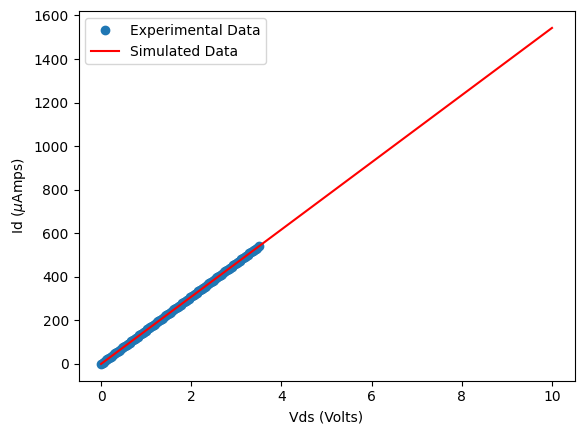

In [20]:
# Generate simulated data using the optimized parameters
simulated_Id = I_V_function(fit_Vds, *optimized_params)

# Plot experimental and simulated data
plt.plot(experimental_Vds, experimental_Id, label='Experimental Data', marker='o', linestyle='None')
plt.plot(fit_Vds, simulated_Id, label='Simulated Data', linestyle='-', color='red')

# Add labels, legend, etc.
plt.xlabel('Vds (Volts)')
plt.ylabel(r'Id ($\mu$Amps)')
plt.legend()
plt.show()